In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#url = "C:/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/"
#url='/mnt/c/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/'
#url = 'C:/Users/USER/OneDrive - DCCP/Documents/comunicaciones dpto/Reporte_cifras_MP_automatizado'
url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos


#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')


#Borrar
AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 8

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

anoReg = AnoReg
anoRegM = AnoRegM1

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [5]:

############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df, mnd):
    nctxt = {}
    nctxt['totReg'+mnd]     = fmtoEntero(   df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+mnd].iloc[0]     , mnd)
    nctxt['totRegOC']       = fmtoEntero(   df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               )
    nctxt['totReg'+mnd+'M'] = fmtoEntero(   df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+mnd].iloc[0]    , mnd)
    nctxt['totRegOCM']      = fmtoEntero(   df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              )
    return nctxt


#
def agregarInsitucionRegion(df, top, mnd):
    print(df)
    nctxt = {}

    #Seleccionar filas del top
    #en estos momentos entra un df con el top 3
    df = df.head(top)
    
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)
    
    for i,row in df.iterrows():
        nctxt['mtoInsReg'+str(i+1)]     = row['NombreInstitucion']
        nctxt['mtoInsReg'+mnd+str(i+1)] = fmtoEntero(row['MONTO'+mnd], mnd)
    return nctxt


#Retorna diccionario con transado por rubro por región
#(dataframe filtrado por región, top, moneda a usar)
def agregarMontoRubrosRegion(df, top, mnd):
    nctxt = {}

    #Seleccionar filas del top
    #en estos momentos entra un df con el top 3
    df = df.head(top)
    
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    for i,row in df.iterrows():
        nctxt['mtoRubReg'+str(i+1)]     = row['RubroN1']
        nctxt['mtoRubReg'+mnd+str(i+1)] = fmtoEntero(row['MONTO'+mnd], mnd)
    return nctxt


# Retorna datos de top OCs de una regón a partir de dataframe
def agregarOrdenCompraRegion(df, mnd): 
    nctxt = {}

    #definir columnas a usar y nombres de variables respectivas
    columnasTabla   = ['NombreInstitucion', 'CodigoOC', 'MotivoCompra', 'NombreSucursal', mnd+'_BRUTO'] #definir en funcion o afuera?
    variablesTabla  = ['ocRegCmp', 'ocRegCod', 'ocRegMot', 'ocRegPrv', 'ocReg'+mnd]
    renomTabla      = dict(zip(columnasTabla, variablesTabla)) #diccionario para renombrar

    df = df[columnasTabla]                      #selecciona columnas
    df = df.rename(columns = renomTabla)        #renombra columnas
    df.reset_index(drop=True, inplace=True)     #resetea index para nombrar bien variables en iteración
    
    for i,row in df.iterrows():                 #df reducido a datos de interes, agrega vars a dicc
        for columna in df.columns:
            if columna == 'ocReg'+mnd:
                nctxt[columna+str(i+1)]     = fmtoEntero(row[columna], mnd) #pasar a operaccion en df
            else:
                nctxt[columna+str(i+1)]     = row[columna]

    return nctxt


#Retorna diccionario con Top especificado de Sectores por Monto transado y región, Moneda a especificar
#(dataframe filtrado por región, Tamaño top, moneda a usar)
def agregarMontoSectorRegion(df, top, mnd):

    #Seleccionar filas de la región y total de monto a usar
    totMnt = df['Monto_Bruto_'+mnd].sum()
    
    #Seleccionar filas del top
    df = df.head(top)
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    nctxt = {}
    for i,row in df.iterrows():
        nctxt['mtoSecReg'+str(i+1)]     = row['Sector']
        nctxt['mtoSecReg'+mnd+str(i+1)] = fmtoEntero(row['Monto_Bruto_'+mnd], mnd)
        nctxt['mtoSecRegPct'+str(i+1)]  = fmtoPorcien(row['Monto_Bruto_'+mnd]/totMnt)
    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, mnd, titGraf):
    
    graf_torta(df['Monto_Bruto_'+mnd], df['Sector'], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'mtoSecRegGrf' : img}
    return dctGrf


def agregarCARegion(df, mnd): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTO'+mnd+'_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTO'+mnd+'_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['mtoCAReg'+mnd]       = fmtoEntero(mto0, mnd)
    nctxt['OCCAReg']            = fmtoEntero(oc0)
    nctxt['mtoCAReg'+mnd+'Var'] = fmtoPorcien(mtoVar)
    nctxt['OCCARegDif']         = fmtoEntero(ocDif)

    return nctxt



#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')




In [6]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 8


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
mndTotReg = 'CLP'
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )


#Query reg pa instituciones
topInsReg = 3
mndInsReg = 'CLP'
InsReg = pd.read_sql(con = conn_DW,  sql = qg.queryInstitucionRegion(mes_i, mes_f) ) #query demorosa casi 2 min


#Montos Rubros Regionales
topRubReg = 3 #la query entrega el top 3, adaptar
mndRubReg = 'USD'
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f) )


#Montos OC Regionales
topOCReg = 5
mndOCReg ='CLP'
OCReg = pd.read_sql(con = conn_DW,  sql = qg.queryOrdenCompraRegion(topOCReg, mes_i, mes_f) )


#Montos Sectores Regionales
topSecReg = 4
mndSecReg = 'CLP'
# llamar query para dfSecReg = QSecReg.loc[QSecReg['region'] == r]
SecReg = pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f) )


#Montos Compra Agils Regional 2022 y 2023
mndCAReg = 'CLP'
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )



Antofagasta
         Region                                  NombreInstitucion  \
0   Antofagasta                        MOP - Dirección de Vialidad   
1   Antofagasta      SERVICIO DE VIVIENDA Y URBANIZACION II REGION   
2   Antofagasta           SERVICIO DE SALUD ANTOFAGASTA HOSPITAL L   
3   Antofagasta                     I MUNICIPALIDAD DE ANTOFAGASTA   
4   Antofagasta                          I MUNICIPALIDAD DE CALAMA   
..          ...                                                ...   
79  Antofagasta                     SECRETARIA GENERAL DE GOBIERNO   
80  Antofagasta                                 Ministerio Publico   
81  Antofagasta  CORPORACION MUNICIPAL DE DEPORTES Y RECREACIÓN...   
82  Antofagasta     Servicio Local de Educación Pública Licancabur   
83  Antofagasta  UNIDAD ADMINISTRADORA DE LOS TRIBUNALES TRIBUT...   

        MONTOUSD      MONTOCLF      MONTOCLP  CantOC  CantProveedores  
0   5.601342e+07  1.262682e+06  4.555110e+10     251              137  
1 

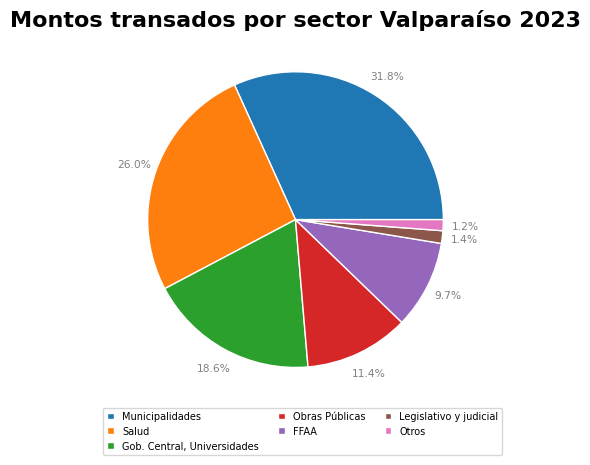

In [7]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

dicGlob = {}

#Iterador de regiones/documentos
for r in listReg:
    print('')
    print(r)
    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg, mndTotReg))

    rInsReg = InsReg.loc[InsReg['Region'] == r]
    contexto.update(agregarInsitucionRegion(rInsReg, topInsReg, 'CLP')) #mndInsReg))

    rRubReg = RubReg.loc[RubReg['Region'] == r]
    contexto.update(agregarMontoRubrosRegion(rRubReg, topRubReg, mndRubReg))

    rOCReg = OCReg.loc[OCReg['Region'] == r]
    contexto.update(agregarOrdenCompraRegion(rOCReg, mndOCReg))

    rSecReg = SecReg.loc[SecReg['region'] == r]
    contexto.update(agregarMontoSectorRegion(rSecReg, topSecReg, mndSecReg))
    titGrafSecReg = contexto['nomCt'] + ' ' + str(anoReg)
    contexto.update(agregarGrafMontoSectorRegion(rSecReg, mndSecReg, titGrafSecReg)) #remover grafico despues de renderizar

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg, mndCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    nomDocu = 'ProtoReporte ' + contexto['nomCt'] + ' ' + str(anoReg)
    docu.save('reportes/'+nomDocu+' con var.docx')


In [8]:

# dfGlob = pd.DataFrame(dicGlob)
# dfGlob.to_excel('dfGlob.xlsx')

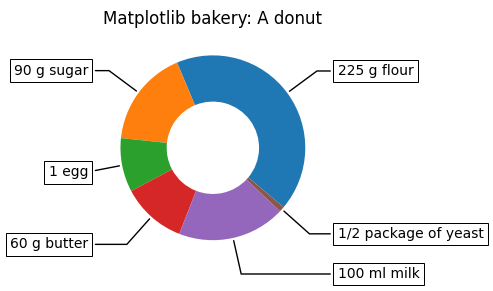

In [9]:
#####################################################
###    Referencia/Ejemplo para refinar gráfico    ###
#####################################################

#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
###########################
#   Probar Crear Tablas   #
###########################

#Importar template
docu = DocxTemplate("tablas.docx")

#Settear diccionario nacional
contexto = {'ano' : str(anoReg),
               'anoM' : str(anoRegM)}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

tttt =  """
        <table>
            <tr>
                <th>Institución</th>
                <th>Código orden de compra</th>
                <th>Motivo de la compra</th>
                <th>Proveedor</th>
                <th>Monto comprometido en US$</th>
            </tr>
            <tr>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
            </tr>
            
        </table>
        """

print('')

contexto['tablita'] = tttt

print(contexto)
docu.render(contexto)
docu.save('tablasnew.docx')


{'ano': '2023', 'anoM': '2022', 'tablita': '\n        <table>\n            <tr>\n                <th>Institución</th>\n                <th>Código orden de compra</th>\n                <th>Motivo de la compra</th>\n                <th>Proveedor</th>\n                <th>Monto comprometido en US$</th>\n            </tr>\n            <tr>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n            </tr>\n            \n        </table>\n        '}
